## Preparing data

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import IndexToString
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F
from itertools import product
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, sum as _sum, when
import time
from typing import Dict, List, Tuple
from pyspark.ml.feature import FeatureHasher, Imputer

In [0]:
# Mount base directory
data_BASE_DIR = "dbfs:/student-groups/Group_4_1/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/student-groups/Group_4_1/08f51b3e-da58-4e4d-9da0-e331eeb9b245/,08f51b3e-da58-4e4d-9da0-e331eeb9b245/,0,1765135660333
dbfs:/student-groups/Group_4_1/3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,0,1765135660333
dbfs:/student-groups/Group_4_1/5Y/,5Y/,0,1765135660333
dbfs:/student-groups/Group_4_1/86b0469f-b9c6-4218-8869-aaeb39753cac/,86b0469f-b9c6-4218-8869-aaeb39753cac/,0,1765135660334
dbfs:/student-groups/Group_4_1/airport_codes.parquet/,airport_codes.parquet/,0,1765135660334
dbfs:/student-groups/Group_4_1/best_preds_final_test_5Y.parquet/,best_preds_final_test_5Y.parquet/,0,1765135660334
dbfs:/student-groups/Group_4_1/c505789c-684a-47b9-84e1-24d52ec7cb99/,c505789c-684a-47b9-84e1-24d52ec7cb99/,0,1765135660334
dbfs:/student-groups/Group_4_1/cv_model/,cv_model/,0,1765135660334
dbfs:/student-groups/Group_4_1/df_test_scaled.parquet/,df_test_scaled.parquet/,0,1765135660334
dbfs:/student-groups/Group_4_1/df_test_scaled_checkpoint.parquet/,df_test_scaled_checkpoint.parquet/,0,1765135660334


In [0]:
# Load 5 year dataset
df_otpw_5y = spark.read.parquet("dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_7/")
print("5-year rows:", df_otpw_5y.count(), " / columns:", len(df_otpw_5y.columns))
print("5-year columns:", df_otpw_5y.columns)

5-year rows: 26650801  / columns: 53
5-year columns: ['FL_DATE', 'ORIGIN', 'HourlyPrecipitation', 'HourlySeaLevelPressure', 'DEP_DELAY_GROUP', 'DEP_TIME', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'QUARTER', 'day_of_week', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'ts_date', 'DISTANCE_GROUP', 'DISTANCE', 'CRS_ELAPSED_TIME', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'season', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'HourlySkyConditions', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day'

In [0]:
# Function to check nulls for a dataframe
def null_summary(df):
    total_rows = df.count()

    # Compute null count and percentage per column
    null_summary = df.select([
        _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in df.columns
    ]).toPandas().T.reset_index()

    null_summary.columns = ["Column", "Null_Count"] 
    null_summary["Null_%"] = (null_summary["Null_Count"] / total_rows * 100).round(2)

    # Sort by highest missing percentage
    null_summary = null_summary.sort_values(by="Null_%", ascending=False).reset_index(drop=True)

    return null_summary

# Function to select dataframe and columns
def select_df(df, columns):
    return df.select(columns)
    
# Function to create departure delay classification groups
def create_delay_groups(df):
    return df.withColumn(
        'DEP_DELAY_GROUP_CLASSIFIED',
        when(col("DEP_DELAY_GROUP") >= 1, 'delayed')
        .otherwise('not_delayed')
    )

In [0]:
null_summary(df_otpw_5y)

,Column,Null_Count,Null_%
0,FL_DATE,0,0.0
1,ORIGIN,0,0.0
2,HourlyPrecipitation,0,0.0
3,HourlySeaLevelPressure,0,0.0
4,DEP_DELAY_GROUP,0,0.0
5,DEP_TIME,0,0.0
6,HourlyWetBulbTemperature,0,0.0
7,HourlyStationPressure,0,0.0
8,HourlyWindSpeed,0,0.0
9,HourlyRelativeHumidity,0,0.0


In [0]:
# Select columns to keep
selected_columns = ['FL_DATE', 'HourlyPrecipitation', 'HourlySeaLevelPressure', 'DEP_DELAY_GROUP', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'QUARTER', 'day_of_week', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE_GROUP', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'season', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'HourlySkyConditions', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption']

In [0]:
# Create delay groups
df_5y = select_df(df_otpw_5y, selected_columns)
df_5y = create_delay_groups(df_5y)

In [0]:
# Create year column, derive from FL_DATE
df_5y = df_5y.withColumn("YEAR", F.year("FL_DATE"))
df_5y.select("FL_DATE", "YEAR").show(10, truncate=False)

+----------+----+
|FL_DATE   |YEAR|
+----------+----+
|2019-06-27|2019|
|2019-01-28|2019|
|2018-04-04|2018|
|2019-05-06|2019|
|2018-09-27|2018|
|2019-05-18|2019|
|2018-03-29|2018|
|2019-12-02|2019|
|2019-06-20|2019|
|2019-07-28|2019|
+----------+----+
only showing top 10 rows


In [0]:
# Check columns schema
df_5y.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: string (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- QUARTER: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- DISTANCE_GROUP: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- Hourl

In [0]:
# Cast numeric-like categoricals to doubles
to_cast_numeric = ["ELEVATION", "LATITUDE", "LONGITUDE", "DISTANCE"]
for c in to_cast_numeric:
    df_5y = df_5y.withColumn(c, F.col(c).cast("double"))
# Drop FL_DATE
df_5y = df_5y.drop("FL_DATE")

In [0]:
# Check null values again
print(null_summary(df_5y))
# Check sample data
display(df_5y.limit(5))

                         Column  Null_Count  Null_%
0           HourlyPrecipitation           0     0.0
1        HourlySeaLevelPressure           0     0.0
2               DEP_DELAY_GROUP           0     0.0
3      HourlyWetBulbTemperature           0     0.0
4         HourlyStationPressure           0     0.0
5               HourlyWindSpeed           0     0.0
6        HourlyRelativeHumidity           0     0.0
7     HourlyDewPointTemperature           0     0.0
8      HourlyDryBulbTemperature           0     0.0
9              HourlyVisibility           0     0.0
10                      QUARTER           0     0.0
11                  day_of_week           0     0.0
12            ORIGIN_AIRPORT_ID           0     0.0
13              DEST_AIRPORT_ID           0     0.0
14                    ELEVATION           0     0.0
15                    LONGITUDE           0     0.0
16                     LATITUDE           0     0.0
17               DISTANCE_GROUP           0     0.0
18          

HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,QUARTER,day_of_week,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ELEVATION,LONGITUDE,LATITUDE,DISTANCE_GROUP,DISTANCE,month,HourlyAltimeterSetting,is_us_holiday,is_holiday_window,is_summer_peak,season,is_weekday,is_superbowl_window,hour_of_day,is_weekend,is_CES_window,is_CES_LasVegas_Peak,is_GHC_window,is_GHC_Host_Airport_Peak,route_avg_delay_last_7days,origin_avg_delay_last_7days,dest_avg_delay_last_7days,Weather_Index,HourlySkyConditions,CRS_DEP_TIME_SIN,CRS_DEP_TIME_COS,is_disaster_day,days_since_disaster,disaster_severity,is_disruption_day,is_airport_disrupted,is_federal_shutdown_day,disruption_severity,days_into_disruption,DEP_DELAY_GROUP_CLASSIFIED,YEAR
0.0,0.0,1,57.0,29.89,7.0,63.0,51.0,64.0,10.0,2,4,10666,13796,45.4,-122.53722,48.79389,4,764.0,6,30.05,0,0,1,Summer,1,0,22,0,0,0,0,0,10.66578947368421,8.10945920832559,11.109813896958826,-2.680075703226438,partly cloudy,-0.8216469379421633,-0.5699967625963036,0,0,0,0,0,0,0,0,delayed,2019
0.0,30.35,-1,40.0,30.16,10.0,39.0,26.0,50.0,10.0,1,1,10666,13796,45.4,-122.53722,48.79389,4,764.0,1,30.33,0,0,0,Winter,1,0,16,0,0,0,0,0,10.66578947368421,8.10945920832559,11.109813896958826,2.0019998397604226,clear sky,0.8660254037844387,-0.4999999999999998,0,0,0,0,0,0,0,0,not_delayed,2019
0.02,30.11,0,44.0,29.93,0.0,83.0,41.0,46.0,10.0,2,3,10666,13796,45.4,-122.53722,48.79389,4,764.0,4,30.09,0,0,0,Spring,1,0,16,0,0,0,0,0,10.66578947368421,8.10945920832559,11.109813896958826,0.9475240907299838,partly cloudy,0.5336145159156117,-0.8457278217039732,0,0,0,0,0,0,0,0,not_delayed,2018
0.0,29.97,0,53.0,29.79,5.0,64.0,47.0,59.0,10.0,2,1,10666,13796,45.4,-122.53722,48.79389,4,764.0,5,29.95,0,0,0,Spring,1,0,21,0,0,0,0,0,10.66578947368421,8.10945920832559,11.109813896958826,0.017406692179751743,clear sky,-0.5299192642332048,-0.8480480961564261,0,0,0,0,0,0,0,0,not_delayed,2019
0.0,30.06,2,61.0,29.88,6.0,61.0,55.0,69.0,10.0,3,4,10666,13796,45.4,-122.53722,48.79389,4,764.0,9,30.04,0,0,0,Fall,1,0,16,0,0,0,1,0,10.66578947368421,8.10945920832559,11.109813896958826,-0.6553823388819278,clear sky,0.5299192642332049,-0.848048096156426,0,0,0,0,0,0,0,0,delayed,2018


## Building baseline model - logistic regression without cross validation


In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import IndexToString
import matplotlib.pyplot as plt
import seaborn as sns

### One year data for training the model

In [0]:
# Split train and test data
train_df = df_5y.filter(col("QUARTER").isin(1, 2, 3))
test_df  = df_5y.filter(col("QUARTER") == 4)
# Identify numeric feature columns (baseline: numeric only, no extra encoding)
label_col = "DEP_DELAY_GROUP_CLASSIFIED"
leakage_cols = {"DEP_DELAY_GROUP"}
numeric_cols = [
    c for c, t in df_5y.dtypes
    if t in ("int","bigint","double","float") and (c != label_col) and (c not in leakage_cols)
]
categorical_cols = [c for c, t in df_5y.dtypes if (t == "string") and (c != label_col) and (c not in leakage_cols)]
print("Numeric features:", numeric_cols)
print("Categorical (one-hot):", categorical_cols)

Numeric features: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Categorical (one-hot): ['QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_GROUP', 'season', 'HourlySk

In [0]:
train_df.select("DEP_DELAY_GROUP_CLASSIFIED") \
        .distinct() \
        .show(truncate=False)

train_df.groupBy("DEP_DELAY_GROUP_CLASSIFIED") \
        .count() \
        .show(truncate=False)

+--------------------------+
|DEP_DELAY_GROUP_CLASSIFIED|
+--------------------------+
|delayed                   |
|not_delayed               |
+--------------------------+

+--------------------------+--------+
|DEP_DELAY_GROUP_CLASSIFIED|count   |
+--------------------------+--------+
|delayed                   |3724939 |
|not_delayed               |16386027|
+--------------------------+--------+



In [0]:
# Function to build the model
def logistic_baseline(train, test):
    # Avoid one-hot explosion for very high-cardinality IDs
    high_card = [c for c in ["TAIL_NUM"] if c in categorical_cols]
    ohe_cols   = [c for c in categorical_cols if c not in high_card]
    idx_only   = high_card  # keep as indexed numeric

    # stages
    label_indexer = StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep")

    cat_indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep")
        for c in (ohe_cols + idx_only)
    ]

    ohe = OneHotEncoder(
        inputCols=[f"{c}__idx" for c in ohe_cols],
        outputCols=[f"{c}__oh"  for c in ohe_cols],
        handleInvalid="keep"
    )

    assembler_inputs = numeric_cols + [f"{c}__oh" for c in ohe_cols] + [f"{c}__idx" for c in idx_only]
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

    # Define Logistic Regression model 
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50,
        regParam=0.0,        # no regularization for a very simple baseline
        elasticNetParam=0.0  # pure L2 would be 0.0 with regParam>0
    )

    # Build the pipeline (label indexer -> assembler -> logistic regression)
    baseline_lr_pipeline = Pipeline(stages=[label_indexer] + cat_indexers + [ohe, assembler, lr])

    # Fit the model on the training set
    baseline_lr_model = baseline_lr_pipeline.fit(train)

    # Make predictions on the test set
    pred_test = baseline_lr_model.transform(test)

    # Convert predictions to RDD: (prediction, label) as floats
    rdd = pred_test.select("prediction", "label") \
                .rdd.map(lambda r: (float(r[0]), float(r[1])))

    mc = MulticlassMetrics(rdd)

    # Identify the numeric index of "delayed"
    label_names = baseline_lr_model.stages[0].labels           # e.g., ['early', 'on_time', 'delayed']
    delayed_idx = float(label_names.index("delayed"))

    # Per-class metrics
    prec_delayed = mc.precision(delayed_idx)
    rec_delayed  = mc.recall(delayed_idx)
    f1_delayed   = 2 * prec_delayed * rec_delayed / (prec_delayed + rec_delayed) \
                if (prec_delayed + rec_delayed) > 0 else 0.0

    print(f"\n--- Per-class metrics for 'delayed' ---")
    print(f"Precision (delayed): {prec_delayed:.4f}")
    print(f"Recall    (delayed): {rec_delayed:.4f}")
    print(f"F1-score  (delayed): {f1_delayed:.4f}")

    # Plot the headmap of the confusion matrix
    confusion_pd = (pred_test
        .groupBy("label", "prediction")
        .count()
        .toPandas()
    )

    cm = (confusion_pd
        .pivot(index="label", columns="prediction", values="count")
        .fillna(0)
        .astype(int))

    # StringIndexer model: numeric label -> string class name
    indexer_model = baseline_lr_model.stages[0]
    label_names = indexer_model.labels  # e.g., ['early', 'on_time', 'delayed']

    # Ensure rows/cols sorted and then cast indices to int
    cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns))

    # Cast float indices (0.0,1.0,2.0) to int before using as list indices
    row_labels = [label_names[int(i)] for i in cm.index]
    col_labels = [label_names[int(j)] for j in cm.columns]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix - Logistic Regression (Baseline)")
    plt.tight_layout()
    plt.show()


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- Per-class metrics for 'delayed' ---
Precision (delayed): 0.4596
Recall    (delayed): 0.0142
F1-score  (delayed): 0.0276


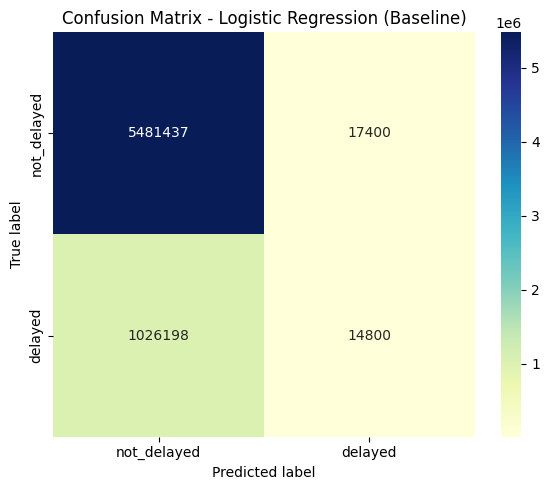

In [0]:
logistic_baseline(train_df, test_df)


### Report evaluation metrics in terms of cross-fold validation over the training set.

In [0]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics 

# --- Build a multinomial Logistic Regression pipeline ---
def _build_lr_pipeline(label_col, numeric_cols, categorical_cols, high_card=("TAIL_NUM",), weight_col=None):
    high_card = [c for c in high_card if c in categorical_cols]
    ohe_cols  = [c for c in categorical_cols if c not in high_card]
    idx_only  = high_card

    label_idx = StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep")
    cat_idx   = [StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep")
                 for c in (ohe_cols + idx_only)]
    ohe = OneHotEncoder(
        inputCols=[f"{c}__idx" for c in ohe_cols],
        outputCols=[f"{c}__oh"  for c in ohe_cols],
        handleInvalid="keep"
    )
    assembler = VectorAssembler(
        inputCols = numeric_cols + [f"{c}__oh" for c in ohe_cols] + [f"{c}__idx" for c in idx_only],
        outputCol = "features",
        handleInvalid = "skip"
    )

    lr = LogisticRegression(
        featuresCol="features", labelCol="label",
        predictionCol="prediction", probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50, regParam=0.0, elasticNetParam=0.0
    )
    if weight_col is not None:
        lr = lr.setWeightCol(weight_col)

    return Pipeline(stages=[label_idx] + cat_idx + [ohe, assembler, lr])

def plot_confusion_matrix_for_fold(pred_df, model, title="Confusion Matrix"):
    """
    Plots a confusion matrix heatmap for a Spark predictions DataFrame.
    Expects columns: 'label' (indexed) and 'prediction' (indexed).
    """
    # Class names from the StringIndexer (in the pipeline's first stage)
    label_names = model.stages[0].labels  # e.g., ['early','on_time','delayed']
    k = len(label_names)

    # Aggregate in Spark (small result), then pivot in pandas
    confusion_pd = (
        pred_df
        .groupBy("label", "prediction")
        .count()
        .toPandas()
    )

    # Build k x k matrix, ensure indices are ints and all cells exist
    if confusion_pd.empty:
        print(f"{title}: (no predictions to display)")
        return

    cm = (confusion_pd
          .pivot(index="label", columns="prediction", values="count")
          .fillna(0))

    # Make sure row/col indices are ints and reindex to full square [0..k-1]
    cm.index = cm.index.astype(int)
    cm.columns = cm.columns.astype(int)
    cm = cm.reindex(index=range(k), columns=range(k), fill_value=0).astype(int)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=label_names, yticklabels=label_names,
                cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- QUARTER-based rolling CV on training quarters (Q1→Q2, Q1+Q2→Q3) ---
def quarter_time_cv_report_multiclass(
    df,
    quarter_col="QUARTER",
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    leakage_cols={"DEP_DELAY_GROUP"},
    numeric_cols=None,
    categorical_cols=None,
    use_class_weights=False
):
    # keep only training quarters 1..3
    train_df = df.filter(F.col(quarter_col).isin(1, 2, 3))

    # infer features if not provided
    if numeric_cols is None:
        numeric_cols = [c for c,t in train_df.dtypes
                        if t in ("int","bigint","double","float") and c != label_col and c not in leakage_cols]
    if categorical_cols is None:
        categorical_cols = [c for c,t in train_df.dtypes if t == "string" and c != label_col]

    # optional class weights on TRAIN only (helps imbalance across 3 classes)
    weight_col = None
    if use_class_weights:
        counts = train_df.groupBy(label_col).count().withColumnRenamed("count","cnt").collect()
        total, k = sum(r["cnt"] for r in counts), len(counts)
        weights = {r[label_col]: float(total)/(k*r["cnt"]) for r in counts}  # inverse frequency
        mapping = F.create_map(*sum(([F.lit(k), F.lit(v)] for k,v in weights.items()), []))
        train_df = train_df.withColumn("class_weight", mapping[F.col(label_col)])
        weight_col = "class_weight"
        print("Class weights:", weights)

    # folds: [Q1]→Q2, [Q1,Q2]→Q3
    folds = [
        (train_df.filter(F.col(quarter_col) == 1),
         train_df.filter(F.col(quarter_col) == 2)),
        (train_df.filter(F.col(quarter_col).isin(1, 2)),
         train_df.filter(F.col(quarter_col) == 3)),
    ]

    acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    f1w_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    wp_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    wr_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

    fold_scores = []
    for i, (tr, va) in enumerate(folds, start=1):
        pipe  = _build_lr_pipeline(label_col, numeric_cols, categorical_cols, weight_col=weight_col)
        model = pipe.fit(tr)
        pred  = model.transform(va)

        # per-class precision/recall via MulticlassMetrics (use float labels)
        labels = model.stages[0].labels  # e.g., ['early','on_time','delayed']
        rdd = pred.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))
        mc  = MulticlassMetrics(rdd)

        per_class = []
        for idx, name in enumerate(labels):
            p_i = mc.precision(float(idx))       # pass float label index
            r_i = mc.recall(float(idx))          # pass float label index
            f_i = 2*p_i*r_i/(p_i+r_i) if (p_i+r_i) > 0 else 0.0  # compute F1 manually to avoid Py4J issues
            per_class.append((name, p_i, r_i, f_i))

        # (optional) macro-averages across classes
        macro_prec = sum(p for _, p, _, _ in per_class) / len(per_class)
        macro_rec  = sum(r for _, _, r, _ in per_class) / len(per_class)
        macro_f1   = sum(f for _, _, _, f in per_class) / len(per_class)

        for name, p_i, r_i, f_i in per_class:
            print(f"{name:10s}  P={p_i:.3f}  R={r_i:.3f}  F1={f_i:.3f}")
        print(f"MACRO P={macro_prec:.3f}  R={macro_rec:.3f}  F1={macro_f1:.3f}")

        # Plot confusion matrix for this fold
        plot_confusion_matrix_for_fold(pred, model, title=f"Confusion Matrix — Fold {i}")


Class weights: {'delayed': 2.699502730111822, 'not_delayed': 0.6136620548715073}


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


not_delayed  P=0.880  R=0.558  F1=0.683
delayed     P=0.267  R=0.679  F1=0.383
MACRO P=0.574  R=0.619  F1=0.533


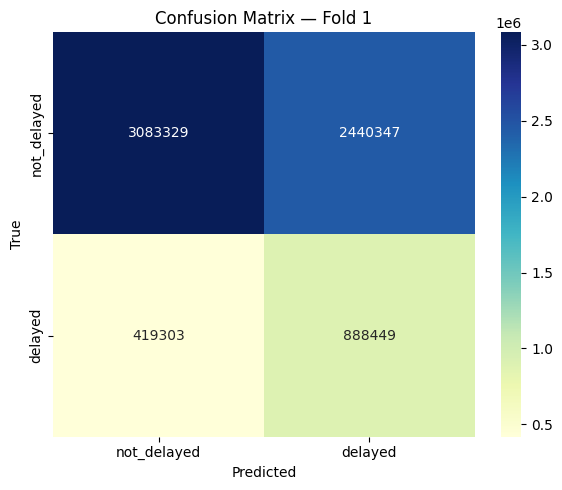

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


not_delayed  P=0.912  R=0.325  F1=0.479
delayed     P=0.226  R=0.863  F1=0.358
MACRO P=0.569  R=0.594  F1=0.419


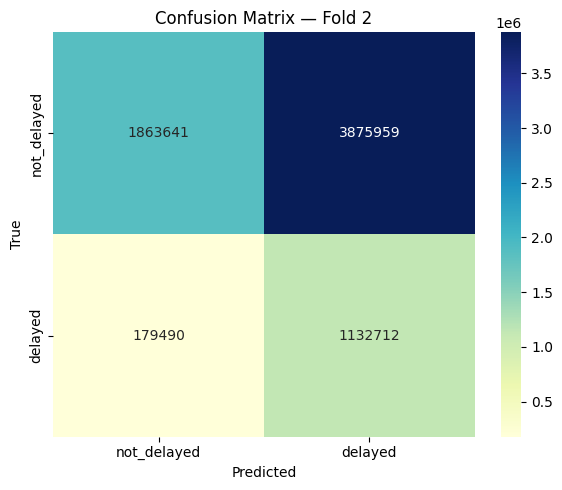

In [0]:

quarter_time_cv_report_multiclass(
    df_5y,
    quarter_col="QUARTER",
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    use_class_weights=True
)

### Hyper-parameter search, adjust class imbalance and CV 

In [0]:
from pyspark.sql.functions import col

label_col = "DEP_DELAY_GROUP_CLASSIFIED"
leakage_cols = {"DEP_DELAY_GROUP"}

# scalar numeric features
numeric_cols = [
    c for c, t in df_5y.dtypes
    if t in ("int", "bigint", "double", "float")
    and c != label_col
    and c not in leakage_cols
]

# already one-hot encoded vector features
vector_cols = [c for c, t in df_5y.dtypes if t == "vector"]

# remaining string categorical features (for you it's probably just 'season')
categorical_cols = [
    c for c, t in df_5y.dtypes
    if t == "string" and c != label_col
]

print("Numeric cols:", numeric_cols)
print("Vector cols:", vector_cols)
print("Categorical cols:", categorical_cols)

Numeric cols: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Vector cols: []
Categorical cols: ['DEP_DELAY_GROUP', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_G

In [0]:
train_df = df_5y.filter(col("QUARTER").isin(1, 2, 3))
test_df  = df_5y.filter(col("QUARTER") == 4)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

def build_lr_pipeline_binary(label_col,
                             numeric_cols,
                             vector_cols,
                             categorical_cols,
                             weight_col=None,
                             regParam=0.0,
                             elasticNetParam=0.0):
    """
    Binary logistic regression pipeline for label_col, with:
      - StringIndexer on label
      - StringIndexer + OneHotEncoder on categorical_cols
      - VectorAssembler over numeric + vector + one-hot
      - LogisticRegression with optional weightCol
    """
    stages = []

    # label indexer (string -> 0/1)
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep"
    )
    stages.append(label_indexer)

    # index + OHE for string categorical (e.g., 'season')
    cat_indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep")
        for c in categorical_cols
    ]
    stages.extend(cat_indexers)

    if categorical_cols:
        ohe = OneHotEncoder(
            inputCols=[f"{c}__idx" for c in categorical_cols],
            outputCols=[f"{c}__oh"  for c in categorical_cols],
            handleInvalid="keep"
        )
        stages.append(ohe)
        ohe_cols = [f"{c}__oh" for c in categorical_cols]
    else:
        ohe_cols = []

    # assemble numeric + vector + one-hot into "features"
    assembler_inputs = numeric_cols + vector_cols + ohe_cols

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features",
        handleInvalid="skip"
    )
    stages.append(assembler)

    # logistic regression (let Spark infer binomial since there are 2 classes)
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50,
        regParam=regParam,
        elasticNetParam=elasticNetParam
    )
    if weight_col is not None:
        lr = lr.setWeightCol(weight_col)

    stages.append(lr)

    return Pipeline(stages=stages)

In [0]:
from pyspark.sql import functions as F

def add_class_weights(df, label_col, alpha=1.0):
    """
    Compute inverse-frequency class weights (to the power alpha)
    on df for label_col, and return df with a new column 'class_weight'.
    """
    counts = df.groupBy(label_col).count().withColumnRenamed("count", "cnt").collect()
    total = sum(r["cnt"] for r in counts)
    k = len(counts)

    # python dict just for printing
    weights_py = {}
    mapping_pairs = []
    for r in counts:
        label_val = r[label_col]
        base_w = float(total) / (k * float(r["cnt"]))   # inverse frequency
        w = base_w ** float(alpha)
        weights_py[label_val] = w
        mapping_pairs.extend([F.lit(label_val), F.lit(w)])

    print(f"Class weights for alpha={alpha}:", weights_py)

    mapping = F.create_map(*mapping_pairs)
    df_with_w = df.withColumn("class_weight", mapping[F.col(label_col)])
    return df_with_w

In [0]:
from itertools import product
from pyspark.mllib.evaluation import MulticlassMetrics

def grid_search_lr_by_recall(
    df,
    quarter_col="QUARTER",
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numeric_cols=None,
    vector_cols=None,
    categorical_cols=None,
    alphas=(0.5, 1.0),
    regParams=(0.0, 1e-3, 1e-2),
    elasticNetParams=(0.0, 0.5)
):
    """
    Time-based CV grid search for binary LR, selecting by recall for 'delayed'.
    Uses training quarters Q1–Q3 with folds:
      - Fold 1: train Q1, validate Q2
      - Fold 2: train Q1+Q2, validate Q3
    """

    # restrict to training quarters
    train_df = df.filter(F.col(quarter_col).isin(1, 2, 3))

    # infer feature lists if not provided
    if numeric_cols is None:
        numeric_cols = [c for c, t in train_df.dtypes
                        if t in ("int", "bigint", "double", "float")
                        and c != label_col
                        and c != "DEP_DELAY_GROUP"]
    if vector_cols is None:
        vector_cols = [c for c, t in train_df.dtypes if t == "vector"]
    if categorical_cols is None:
        categorical_cols = [c for c, t in train_df.dtypes
                            if t == "string" and c != label_col]

    print("Using numeric_cols:", numeric_cols)
    print("Using vector_cols:", vector_cols)
    print("Using categorical_cols:", categorical_cols)

    # define time-based folds
    folds = [
        (train_df.filter(F.col(quarter_col) == 1),
         train_df.filter(F.col(quarter_col) == 2)),
        (train_df.filter(F.col(quarter_col).isin(1, 2)),
         train_df.filter(F.col(quarter_col) == 3)),
    ]

    results = []  # will hold all configs + metrics

    for alpha, regP, ela in product(alphas, regParams, elasticNetParams):
        print(f"\n=== Trying alpha={alpha}, regParam={regP}, elasticNetParam={ela} ===")

        # 1) Add class weights ONCE for this alpha to Q1–Q3
        train_weighted = add_class_weights(train_df, label_col, alpha=alpha)

        # 2) Define folds using the weighted df for training
        folds = [
            (
                train_weighted.filter(F.col(quarter_col) == 1),          # train
                train_df.filter(F.col(quarter_col) == 2)                 # validate (no weights needed)
            ),
            (
                train_weighted.filter(F.col(quarter_col).isin(1, 2)),    # train
                train_df.filter(F.col(quarter_col) == 3)                 # validate
            ),
        ]

        fold_recalls = []
        fold_precisions = []
        fold_f1s = []

        for fold_idx, (tr_w, va) in enumerate(folds, start=1):

            # 3) Build & fit model (weight_col is 'class_weight')
            pipe = build_lr_pipeline_binary(
                label_col=label_col,
                numeric_cols=numeric_cols,
                vector_cols=vector_cols,
                categorical_cols=categorical_cols,
                weight_col="class_weight",
                regParam=regP,
                elasticNetParam=ela,
            )
            model = pipe.fit(tr_w)
            pred = model.transform(va)

            # 4) Get index of 'delayed' in the label indexer
            labels = model.stages[0].labels
            if "delayed" not in labels:
                raise ValueError(f"'delayed' not found in labels: {labels}")
            delayed_idx = float(labels.index("delayed"))

            # 5) Precision / recall / F1 for 'delayed'
            rdd = pred.select("prediction", "label").rdd.map(
                lambda r: (float(r[0]), float(r[1]))
            )
            mc = MulticlassMetrics(rdd)

            prec_delayed = mc.precision(delayed_idx)
            rec_delayed  = mc.recall(delayed_idx)
            f1_delayed   = (2 * prec_delayed * rec_delayed /
                            (prec_delayed + rec_delayed)) if (prec_delayed + rec_delayed) > 0 else 0.0

            print(
                f"  Fold {fold_idx}: "
                f"precision(delayed)={prec_delayed:.4f}, "
                f"recall(delayed)={rec_delayed:.4f}, "
                f"F1(delayed)={f1_delayed:.4f}"
            )

            fold_precisions.append(prec_delayed)
            fold_recalls.append(rec_delayed)
            fold_f1s.append(f1_delayed)

        # 6) Aggregate over folds
        mean_prec = sum(fold_precisions) / len(fold_precisions)
        mean_rec  = sum(fold_recalls)    / len(fold_recalls)
        mean_f1   = sum(fold_f1s)        / len(fold_f1s)

        print(
            f"--> Mean over folds: "
            f"P(delayed)={mean_prec:.4f}, "
            f"R(delayed)={mean_rec:.4f}, "
            f"F1(delayed)={mean_f1:.4f}"
        )

        results.append({
            "alpha": alpha,
            "regParam": regP,
            "elasticNetParam": ela,
            "mean_precision_delayed": mean_prec,
            "mean_recall_delayed": mean_rec,
            "mean_f1_delayed": mean_f1,
        })

    # pick best config by mean recall(delayed)
    results_sorted = sorted(results, key=lambda r: r["mean_recall_delayed"], reverse=True)
    best = results_sorted[0]

    print("\n===== BEST CONFIG (by recall for 'delayed') =====")
    print(best)

    return results_sorted

In [0]:
alphas = [0.5, 1.0, 1.5]
regParams = [0.0, 1e-4, 1e-3, 1e-2]
elasticNetParams = [0.0, 0.5]


results = grid_search_lr_by_recall(
    df_5y,
    quarter_col="QUARTER",
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numeric_cols=numeric_cols,
    vector_cols=vector_cols,
    categorical_cols=categorical_cols,
    alphas=alphas,
    regParams=regParams,
    elasticNetParams=elasticNetParams
)

Using numeric_cols: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Using vector_cols: []
Using categorical_cols: ['QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_GR

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


  Fold 1: precision(delayed)=0.3314, recall(delayed)=0.2208, F1(delayed)=0.2650
  Fold 2: precision(delayed)=0.2869, recall(delayed)=0.5122, F1(delayed)=0.3678
--> Mean over folds: P(delayed)=0.3091, R(delayed)=0.3665, F1(delayed)=0.3164

=== Trying alpha=0.5, regParam=0.0, elasticNetParam=0.5 ===
Class weights for alpha=0.5: {'delayed': 1.64301635113952, 'not_delayed': 0.7833658499523114}
  Fold 1: precision(delayed)=0.3314, recall(delayed)=0.2208, F1(delayed)=0.2650
  Fold 2: precision(delayed)=0.2869, recall(delayed)=0.5122, F1(delayed)=0.3678
--> Mean over folds: P(delayed)=0.3091, R(delayed)=0.3665, F1(delayed)=0.3164

=== Trying alpha=0.5, regParam=0.0001, elasticNetParam=0.0 ===
Class weights for alpha=0.5: {'delayed': 1.64301635113952, 'not_delayed': 0.7833658499523114}
  Fold 1: precision(delayed)=0.3316, recall(delayed)=0.2201, F1(delayed)=0.2646
  Fold 2: precision(delayed)=0.2850, recall(delayed)=0.5195, F1(delayed)=0.3681
--> Mean over folds: P(delayed)=0.3083, R(delayed)=

In [0]:
# Best recall: alpha=1.5, regParam=0.01, elasticNetParam=0.5, P(delayed)=0.2103, R(delayed)=0.9253, F1(delayed)=0.3418
# Best F1: alpha=1.0, regParam=0.001, elasticNetParam=0.5, P(delayed)=0.2927, R(delayed)=0.5751, F1(delayed)=0.3830
# Best Precision: alpha=0.5, regParam=0.001, elasticNetParam=0.5, P(delayed)=0.3715, R(delayed)=0.2224, F1(delayed)=0.2695

### Train model with best parameters and test on Q4

In [0]:
# Split train and test data
train_df = df_5y.filter(col("QUARTER").isin(1, 2, 3))
test_df  = df_5y.filter(col("QUARTER") == 4)
# Identify numeric feature columns (baseline: numeric only, no extra encoding)
label_col = "DEP_DELAY_GROUP_CLASSIFIED"
leakage_cols = {"DEP_DELAY_GROUP"}
numeric_cols = [
    c for c, t in df_5y.dtypes
    if t in ("int","bigint","double","float") and (c != label_col) and (c not in leakage_cols)
]
categorical_cols = [c for c, t in df_5y.dtypes if (t == "string") and (c != label_col) and (c not in leakage_cols)]
print("Numeric features:", numeric_cols)
print("Categorical (one-hot):", categorical_cols)

Numeric features: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Categorical (one-hot): ['QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_GROUP', 'season', 'HourlySk

In [0]:
def logistic_baseline(train, test, use_class_weights=True,
                      alpha=1.5, regParam=0.01, elasticNetParam=0.5):
    """
    Tuned logistic regression with optional class weights.

    - Trains on `train` (Q1–Q3), tests on `test` (Q4)
    - Reports precision/recall/F1 for 'delayed' on TRAIN and TEST
    - Plots confusion matrix on TEST
    """

    # ---------- (1) Optional class weights on TRAIN ONLY ----------
    train_for_fit = train
    weight_col_name = None
    if use_class_weights:
        counts = train.groupBy(label_col).count().withColumnRenamed("count", "cnt")
        total = counts.agg(F.sum("cnt")).first()[0]
        k = counts.count()

        # base inverse-frequency weight: w_c = N / (K * n_c)
        weights_df = counts.withColumn(
            "class_weight",
            F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt"))
        )
        if alpha != 1.0:
            weights_df = weights_df.withColumn(
                "class_weight",
                F.pow(F.col("class_weight"), F.lit(float(alpha)))
            )

        train_for_fit = train.join(
            weights_df.select(label_col, "class_weight"),
            on=label_col,
            how="left"
        )
        weight_col_name = "class_weight"

        print("Class weights:", {r[label_col]: r["class_weight"] for r in weights_df.collect()})

    # ---------- (2) Pipeline: index → OHE → assemble → LR ----------
    high_card = [c for c in ["TAIL_NUM"] if c in categorical_cols]
    ohe_cols  = [c for c in categorical_cols if c not in high_card]
    idx_only  = high_card

    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="skip"   # skip weird labels so we stay binary
    )

    cat_indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep")
        for c in (ohe_cols + idx_only)
    ]

    ohe = OneHotEncoder(
        inputCols=[f"{c}__idx" for c in ohe_cols],
        outputCols=[f"{c}__oh"  for c in ohe_cols],
        handleInvalid="keep"
    )

    assembler_inputs = numeric_cols + [f"{c}__oh" for c in ohe_cols] + [f"{c}__idx" for c in idx_only]
    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features",
        handleInvalid="skip"
    )

    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50,
        regParam=regParam,
        elasticNetParam=elasticNetParam
    )
    if weight_col_name:
        lr = lr.setWeightCol(weight_col_name)

    pipeline = Pipeline(stages=[label_indexer] + cat_indexers + [ohe, assembler, lr])

    # ---------- (3) Fit / Predict ----------
    model = pipeline.fit(train_for_fit)
    pred_train = model.transform(train)
    pred_test  = model.transform(test)

    # Get label names once here so we can reuse them
    label_names = model.stages[0].labels   # e.g. ['not_delayed', 'delayed']
    delayed_idx = float(label_names.index("delayed"))

    # small helper to compute P/R/F1 for 'delayed'
    def prf_for_delayed(pred_df):
        rdd = pred_df.select("prediction", "label") \
                     .rdd.map(lambda r: (float(r[0]), float(r[1])))
        mc = MulticlassMetrics(rdd)

        prec = mc.precision(delayed_idx)
        rec  = mc.recall(delayed_idx)
        f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
        return prec, rec, f1

    # ---------- (4) Metrics ----------
    train_prec, train_rec, train_f1 = prf_for_delayed(pred_train)
    test_prec,  test_rec,  test_f1  = prf_for_delayed(pred_test)

    print("\n=== Metrics for 'delayed' ===")
    print(f"TRAIN (Q1–Q3): precision={train_prec:.4f}, recall={train_rec:.4f}, F1={train_f1:.4f}")
    print(f"TEST  (Q4)   : precision={test_prec:.4f},  recall={test_rec:.4f},  F1={test_f1:.4f}")

    # ---------- (5) Confusion matrix on TEST ----------
    confusion_pd = pred_test.groupBy("label", "prediction").count().toPandas()
    if confusion_pd.empty:
        print("No predictions to show in confusion matrix.")
        return

    cm = (confusion_pd
          .pivot(index="label", columns="prediction", values="count")
          .fillna(0))
    cm.index   = cm.index.astype(int)
    cm.columns = cm.columns.astype(int)

    num_labels = len(label_names)
    keep_rows = [i for i in cm.index   if i < num_labels]
    keep_cols = [j for j in cm.columns if j < num_labels]
    cm = cm.loc[keep_rows, keep_cols].astype(int)

    row_labels = [label_names[i] for i in cm.index]
    col_labels = [label_names[j] for j in cm.columns]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=col_labels, yticklabels=row_labels,
                cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix - Logistic Regression (tuned)")
    plt.tight_layout()
    plt.show()

    return {
        "train_precision_delayed": train_prec,
        "train_recall_delayed": train_rec,
        "train_f1_delayed": train_f1,
        "test_precision_delayed": test_prec,
        "test_recall_delayed": test_rec,
        "test_f1_delayed": test_f1,
    }

Class weights: {'delayed': 4.435327125519498, 'not_delayed': 0.48072189719790026}


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN (Q1–Q3): precision=0.2077, recall=0.9392, F1=0.3402
TEST  (Q4)   : precision=0.1890,  recall=0.8700,  F1=0.3106


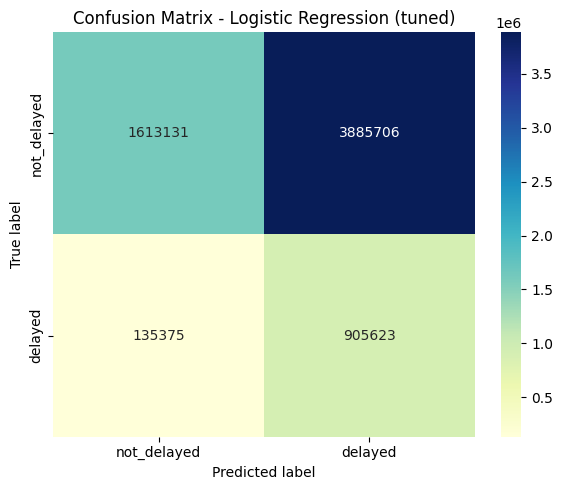

{'train_precision_delayed': 0.20772452009422127,
 'train_recall_delayed': 0.9392121589105218,
 'train_f1_delayed': 0.34020604371226815,
 'test_precision_delayed': 0.1890129022657388,
 'test_recall_delayed': 0.8699565224909174,
 'test_f1_delayed': 0.3105528890955532}

In [0]:
# Based on best recall from grid search, Best recall: alpha=1.5, regParam=0.01, elasticNetParam=0.5, P(delayed)=0.2103, R(delayed)=0.9253, F1(delayed)=0.3418
logistic_baseline(
    train_df,
    test_df,
    use_class_weights=True,
    alpha=1.5,          
    regParam=0.01,      
    elasticNetParam=0.5 
)

Class weights: {'delayed': 2.699502730111822, 'not_delayed': 0.6136620548715073}


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN (Q1–Q3): precision=0.2659, recall=0.6647, F1=0.3799
TEST  (Q4)   : precision=0.2401,  recall=0.4999,  F1=0.3244


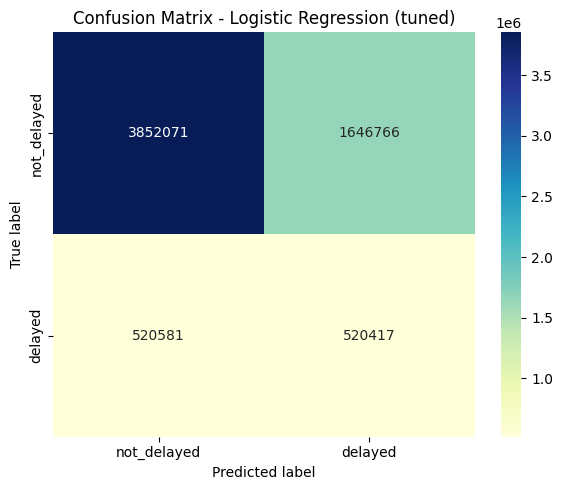

In [0]:
# Based on best F1 from grid search, Best F1: alpha=1.0, regParam=0.001, elasticNetParam=0.5, P(delayed)=0.2927, R(delayed)=0.5751, F1(delayed)=0.3830
# Adjust parameters for experiments
metrics = logistic_baseline(train_df, test_df, use_class_weights=True,
                            alpha=1.0, regParam=0.01, elasticNetParam=0.5)